In [1]:
%matplotlib inline

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16, ResNet50
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing import image
import tensorflow.keras.applications.resnet50 as resnet50
from random import shuffle
from tqdm import tqdm

import matplotlib.pyplot as plt
import os, cv2, shutil, numpy as np
import multiprocessing as mp
from tqdm import tqdm
import operator
import cv2
import numpy as np
import os
import random
import PIL


ALL_DIR = '../res/Proper'
TEST_DIR = '../res/ResTest'
TRAIN_DIR = '../res/ResTrain'
IMG_SIZE_X = 224
IMG_SIZE_Y = 224
LR = 1e-3

In [2]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

def get_immediate_files(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isfile(os.path.join(a_dir, name))]

def copy_proper_species(src,dst):
    species=get_immediate_subdirectories(src)
    print("Copying...")
    for s in tqdm(species):
        if len(get_immediate_files(src+'/'+s)) >= THRESHOLD: #Species of at least THRESHOLD size
            if not os.path.isdir(dst+'/'+s):
                shutil.copytree(src+'/'+s,dst+'/'+s,symlinks=False,ignore=None)

def copy_to_test():
    ratio = 0.1 
    species = get_immediate_subdirectories(TRAIN_DIR)
    for s in species:
        cur_dir = TRAIN_DIR+'/'+s
        images = get_immediate_files(cur_dir)
        img_count = len(images)
        test_count = int(img_count*0.1)
        test_dir = TEST_DIR + '/' + s
        if(test_count < 1):
            print(s, 'has no test data')
        if not os.path.isdir(test_dir):
            os.mkdir(test_dir)

        for i in range(0, test_count):
            images = get_immediate_files(cur_dir)
            img_count = len(images)
            index = random.randint(0, img_count-1)
            img_to_move = images[index]
            os.rename(cur_dir + '/' + img_to_move, test_dir + '/' + img_to_move)

THRESHOLD = 15

In [11]:
copy_proper_species(ALL_DIR, TRAIN_DIR)
copy_to_test()

Copying...


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:26<00:00,  3.29it/s]


In [3]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)
    fig, axes = plt.subplots(3, 3)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i],
                      interpolation=interpolation)
            cls_true_name = class_names[cls_true[i]]

            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                cls_pred_name = class_names[cls_pred[i]]
                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
                
            ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test, 
                          y_pred=cls_pred)

    print("Confusion matrix:")
    print(cm)
    
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))
        
def plot_example_errors(cls_pred):
    incorrect = (cls_pred != cls_test)
    image_paths = np.array(image_paths_test)[incorrect]
    images = load_images(image_paths=image_paths[0:9])
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def example_errors():
    generator_test.reset()
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)
    cls_pred = np.argmax(y_pred,axis=1)
    plot_example_errors(cls_pred)
    print_confusion_matrix(cls_pred)
    

def load_images(image_paths):
    images = [plt.imread(path) for path in image_paths]
    return np.asarray(images)

def plot_training_history(history):
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.show()

In [4]:
labels = os.listdir(TRAIN_DIR)
LABELS_COUNT = len(labels)
MODEL_NAME = 'resnet-cactusifier-{}-{}-{}-12conv2filter2size-02.model'.format(LR, '2conv-basic','treshold_60')

labelCounts = {}
for directory in labels:
    files = os.listdir(os.path.join(TRAIN_DIR, directory))
    labelCounts[directory] = len(files)

print(sum(labelCounts.values()), 'images')
labelCounts = sorted(labelCounts.items(), key=operator.itemgetter(1), reverse = True)
labelCounts

1306 images


[('E Horizontalonius', 161),
 ('A Retusus', 158),
 ('A Myriostigma', 147),
 ('A Kotschoubeyanus', 141),
 ('Th Bicolor', 36),
 ('L Williamsii', 26),
 ('S Disciformis', 25),
 ('R Beguinii', 24),
 ('A valdezii', 22),
 ('C humilis', 22),
 ('H curvispinus', 21),
 ('N Conoidea', 21),
 ('Th Heterochromus', 21),
 ('A Trigonus', 20),
 ('H kunzei', 20),
 ('N subgibbosa', 20),
 ('Ef ochoterenaus', 19),
 ('A lloydii', 18),
 ('C Echinus', 18),
 ('Ep Greggii', 18),
 ('H heinrichianus', 18),
 ('H limariensis', 18),
 ('H Texensis', 18),
 ('Lobivia pampana', 18),
 ('Th esmeraldana', 18),
 ('T nikolae', 17),
 ('Th Multicephalus', 17),
 ('Thelocephala challensis', 17),
 ('A ritteri', 16),
 ('M Candida', 16),
 ('N senilis', 16),
 ('T Valdezianus', 16),
 ('A Fissuratus', 15),
 ('Th Hex', 15),
 ('Th lloydii', 15),
 ('A Coahuilense', 14),
 ('A scaphar', 14),
 ('Ec Pectinatus', 14),
 ('H taltalensis', 14),
 ('M lasiacantha', 14),
 ('Th napina', 14),
 ('Thelocephala glabrescens', 14)]

In [5]:
model = ResNet50(include_top=True, weights='imagenet')
input_shape = model.layers[0].output_shape[1:3]
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=180,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=[0.9, 1.5],
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale=1./255)


In [21]:
batch_size = 64
AUG_DIR = '../res/Augmented/'
generator_train = datagen_train.flow_from_directory(directory=TRAIN_DIR, target_size=input_shape,
                                                   batch_size=batch_size, shuffle=True, save_to_dir=AUG_DIR)
generator_test = datagen_test.flow_from_directory(directory=TEST_DIR, target_size=input_shape,
                                                 batch_size=batch_size, shuffle=False)
steps_test = generator_test.n / batch_size
steps_test

Found 1306 images belonging to 42 classes.
Found 121 images belonging to 42 classes.


1.890625

In [22]:
image_paths_train = path_join(TRAIN_DIR, generator_train.filenames)
image_paths_test = path_join(TEST_DIR, generator_test.filenames)

cls_train = generator_train.classes
cls_test = generator_test.classes

In [23]:
class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes
num_classes

42

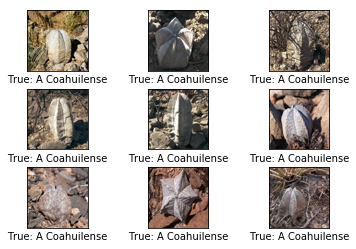

In [24]:
image_paths_train[0]
images = load_images(image_paths=image_paths_train[0:9])
cls_true = cls_train[0:9]
plot_images(images=images, cls_true=cls_true, smooth=True)

In [25]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(cls_train), y=cls_train)
class_weight

array([2.22108844, 2.07301587, 0.2205336 , 0.21153223, 0.1968053 ,
       1.5547619 , 1.72751323, 1.94345238, 2.22108844, 1.41341991,
       1.72751323, 1.41341991, 0.19313812, 2.22108844, 1.63659148,
       1.72751323, 1.72751323, 1.48072562, 1.72751323, 1.5547619 ,
       1.72751323, 2.22108844, 1.1959707 , 1.72751323, 1.94345238,
       2.22108844, 1.48072562, 1.94345238, 1.5547619 , 1.29563492,
       1.24380952, 1.94345238, 1.82913165, 0.86375661, 1.48072562,
       2.07301587, 1.82913165, 1.72751323, 2.07301587, 2.22108844,
       1.82913165, 2.22108844])

In [26]:
def predict(image_path):
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)
    plt.imshow(img_resized)
    plt.show()
    
    img_array=np.expand_dims(np.array(img_resized), axis=0)
    pred = model.predict(img_array)
    pred_decoded = decode_predictions(pred)[0]
    for code,name,score in pred_decoded:
        print("{0:6.2%} : {1}".format(score, name))

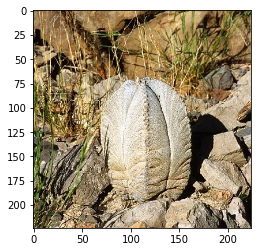

18.89% : spider_web
11.99% : sea_urchin
 3.36% : hen-of-the-woods
 3.24% : fountain
 2.53% : garden_spider


In [27]:
predict(image_path=image_paths_train[0])

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

activation_9 (Activation)       (None, 56, 56, 256)  0           add_2[0][0]                      
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, 28, 28, 128)  32896       activation_9[0][0]               
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 28, 28, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branc

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_6 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_18[0][0]              
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 28, 28, 512)  0           add_6[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_21[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 14, 14, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_32[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_10 (Add)                    (None, 14, 14, 1024) 0           bn4d_branch2c[0][0]              
          

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________

In [29]:
transfer_layer = model.get_layer('avg_pool')
transfer_layer.output

<tf.Tensor 'avg_pool/Mean:0' shape=(?, 2048) dtype=float32>

In [30]:
conv_model = Model(inputs=model.input, outputs = transfer_layer.output)

new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(lr=1e-3)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']

In [31]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [32]:
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False
print_layer_trainable()

False:	input_1
False:	conv1_pad
False:	conv1
False:	bn_conv1
False:	activation
False:	pool1_pad
False:	max_pooling2d
False:	res2a_branch2a
False:	bn2a_branch2a
False:	activation_1
False:	res2a_branch2b
False:	bn2a_branch2b
False:	activation_2
False:	res2a_branch2c
False:	res2a_branch1
False:	bn2a_branch2c
False:	bn2a_branch1
False:	add
False:	activation_3
False:	res2b_branch2a
False:	bn2b_branch2a
False:	activation_4
False:	res2b_branch2b
False:	bn2b_branch2b
False:	activation_5
False:	res2b_branch2c
False:	bn2b_branch2c
False:	add_1
False:	activation_6
False:	res2c_branch2a
False:	bn2c_branch2a
False:	activation_7
False:	res2c_branch2b
False:	bn2c_branch2b
False:	activation_8
False:	res2c_branch2c
False:	bn2c_branch2c
False:	add_2
False:	activation_9
False:	res3a_branch2a
False:	bn3a_branch2a
False:	activation_10
False:	res3a_branch2b
False:	bn3a_branch2b
False:	activation_11
False:	res3a_branch2c
False:	res3a_branch1
False:	bn3a_branch2c
False:	bn3a_branch1
False:	add_3
False:	activa

In [33]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [34]:
epochs = 20
steps_per_epoch = 100

In [ ]:
history = new_model.fit_generator(generator=generator_train, epochs=epochs, steps_per_epoch=steps_per_epoch,
                                 class_weight=class_weight, validation_data=generator_test, validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - ETA: 7:53 - loss: 4.4131 - categorical_accuracy: 0.03 - ETA: 4:03 - loss: 4.1711 - categorical_accuracy: 0.05 - ETA: 2:52 - loss: 4.0453 - categorical_accuracy: 0.07 - ETA: 2:28 - loss: 4.2274 - categorical_accuracy: 0.07 - ETA: 2:28 - loss: 4.0830 - categorical_accuracy: 0.10 - ETA: 2:28 - loss: 3.9514 - categorical_accuracy: 0.12 - ETA: 2:26 - loss: 3.9819 - categorical_accuracy: 0.11 - ETA: 2:24 - loss: 3.9655 - categorical_accuracy: 0.11 - ETA: 2:23 - loss: 3.9420 - categorical_accuracy: 0.13 - ETA: 2:21 - loss: 3.9546 - categorical_accuracy: 0.13 - ETA: 2:21 - loss: 3.9255 - categorical_accuracy: 0.14 - ETA: 2:20 - loss: 3.8547 - categorical_accuracy: 0.15 - ETA: 2:18 - loss: 3.7837 - categorical_accuracy: 0.16 - ETA: 2:17 - loss: 3.7255 - categorical_accuracy: 0.16 - ETA: 2:16 - loss: 3.6635 - categorical_accuracy: 0.17 - ETA: 2:15 - loss: 3.6267 - categorical_accuracy: 0.18 - ETA: 2:13 - loss: 3.5843 - categorical_accuracy: 0

 45/100 [============>.................] - ETA: 17s - loss: 1.5064 - categorical_accuracy: 0.531 - ETA: 25s - loss: 1.5502 - categorical_accuracy: 0.515 - ETA: 1:11 - loss: 1.6218 - categorical_accuracy: 0.50 - ETA: 1:32 - loss: 1.7459 - categorical_accuracy: 0.48 - ETA: 1:44 - loss: 1.8158 - categorical_accuracy: 0.46 - ETA: 1:51 - loss: 1.8219 - categorical_accuracy: 0.46 - ETA: 1:58 - loss: 1.7635 - categorical_accuracy: 0.47 - ETA: 2:00 - loss: 1.7661 - categorical_accuracy: 0.46 - ETA: 2:02 - loss: 1.7567 - categorical_accuracy: 0.47 - ETA: 2:03 - loss: 1.7562 - categorical_accuracy: 0.48 - ETA: 2:06 - loss: 1.7261 - categorical_accuracy: 0.50 - ETA: 2:07 - loss: 1.6948 - categorical_accuracy: 0.51 - ETA: 2:07 - loss: 1.6924 - categorical_accuracy: 0.51 - ETA: 2:06 - loss: 1.7055 - categorical_accuracy: 0.51 - ETA: 1:59 - loss: 1.6851 - categorical_accuracy: 0.52 - ETA: 1:59 - loss: 1.6731 - categorical_accuracy: 0.52 - ETA: 1:59 - loss: 1.6495 - categorical_accuracy: 0.53 - ETA: 

In [ ]:
plot_training_history(history)

In [ ]:
img = image.load_img('../res/Test/ehorizonthalonius.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])